In [2]:
# 1. Các thư viện cần thiết
!pip3 install -U git+https://github.com/PYFTS/pyFTS
import pandas as pd
import numpy as np
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.models import chen
from pyFTS.common import FLR
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Fix the import in the pyFTS library if necessary
# In the file '/usr/local/lib/python3.10/dist-packages/pyFTS/common/transformations/trend.py', change:
# from pandas import datetime
# to:
# from pandas import Timestamp

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-k2q347z5
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-k2q347z5
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done


# **Chia train test validate theo tỉ lệ 8:1:1**

In [19]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('ETH.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [20]:
# 3. Chia train test validate theo tỉ lệ 8:1:1
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


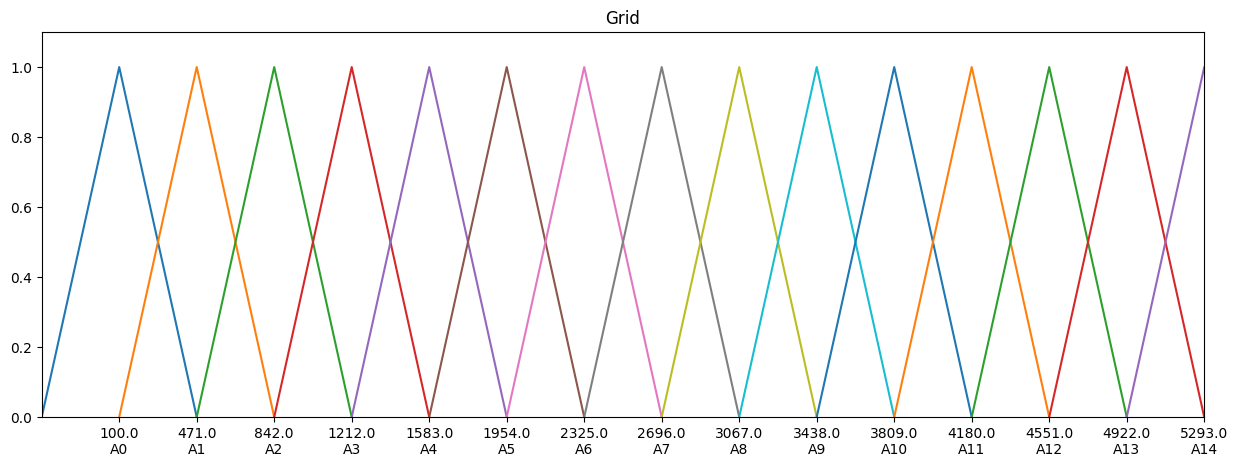

In [21]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [22]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [23]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A0', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A4', 'A6 -> A5', 'A5 -> A3', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A7 -> A5', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A11 -> A9', 'A10 -> A8', 'A8 -> A6', 'A9 -> A6', 'A9 -> A7', 'A8 -> A11', 'A11 -> A8', 'A10 -> A12', 'A11 -> A12', 'A12 -> A10', 'A12 -> A11', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [24]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A0,A1,A2
A2 -> A1,A2,A3
A3 -> A2,A3,A4
A4 -> A3,A4,A5
A5 -> A4,A5,A6,A7
A6 -> A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8,A9
A9 -> A10,A6,A8,A9
A10 -> A10,A11,A9
A11 -> A10,A11,A12
A12 -> A11,A12,A13
A13 -> A12



In [25]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [26]:
# 10. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 191.62454386597008
Testing RMSE: 223.84058163998841
Testing MAPE: 0.09384844858359208
Validation MAE: 121.4361708761388
Validation RMSE: 153.82999216540242
Validation MAPE: 0.04356370414447923


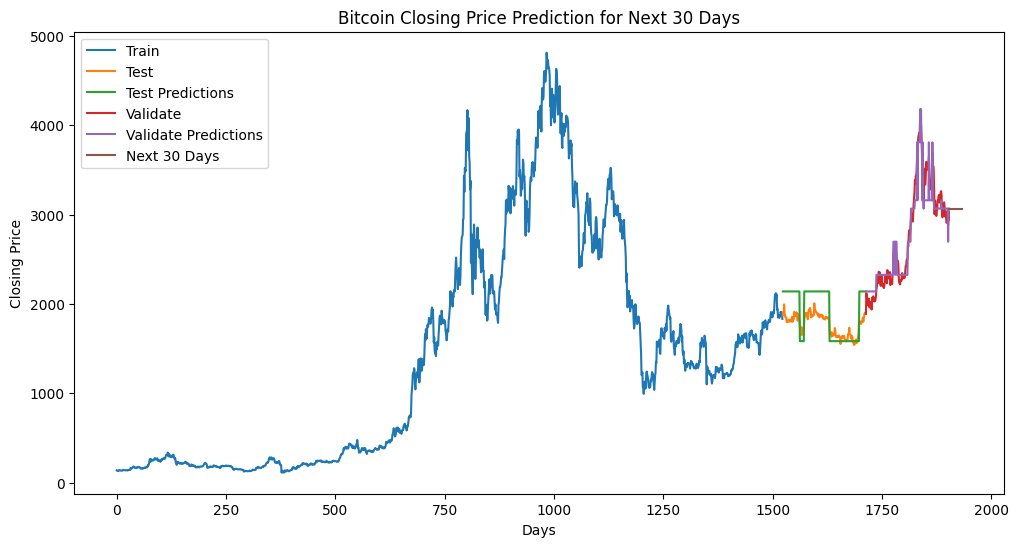

Predicted closing prices for the next 30 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802]


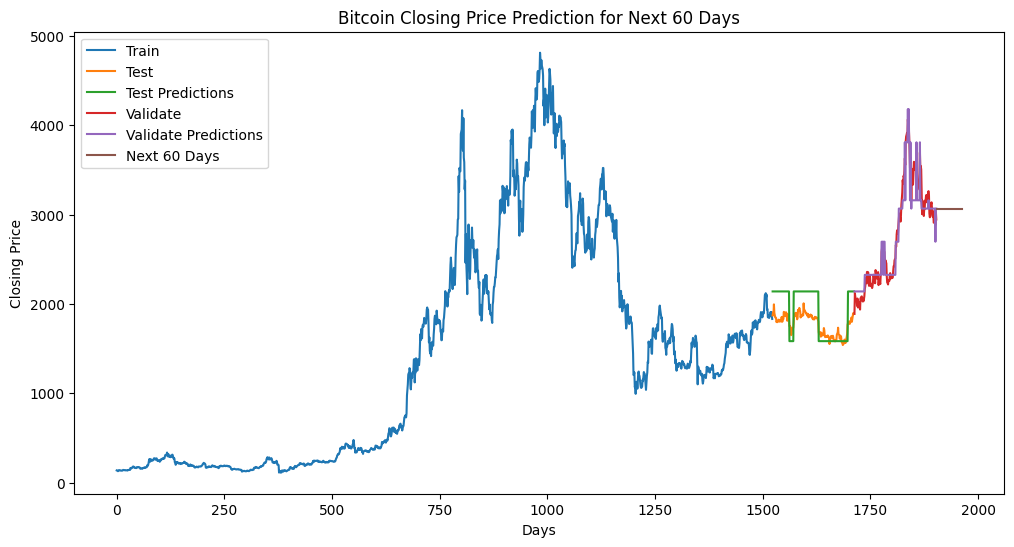

Predicted closing prices for the next 60 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802]


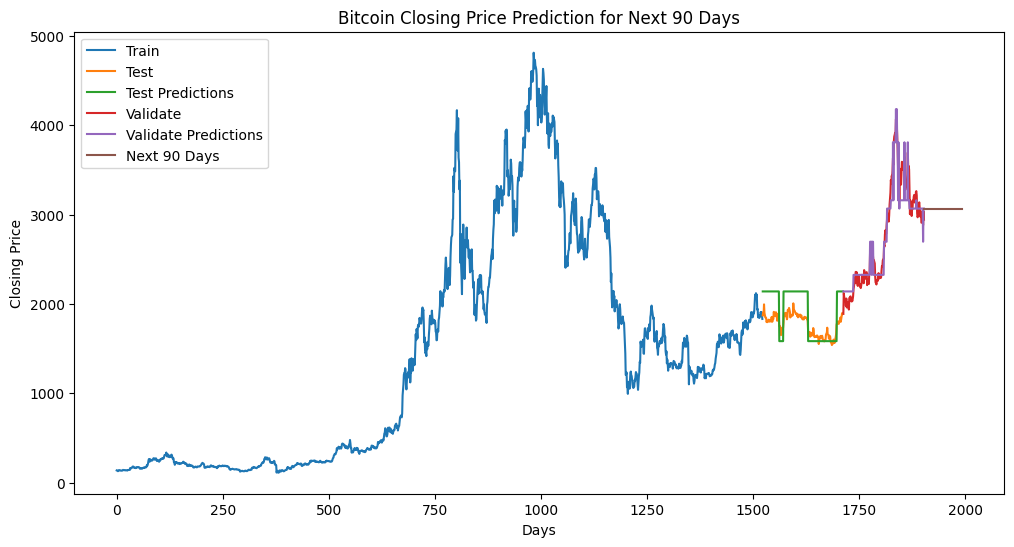

Predicted closing prices for the next 90 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3

In [27]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 7:2:1**

In [28]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('ETH.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [29]:
# 3. Chia train test validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


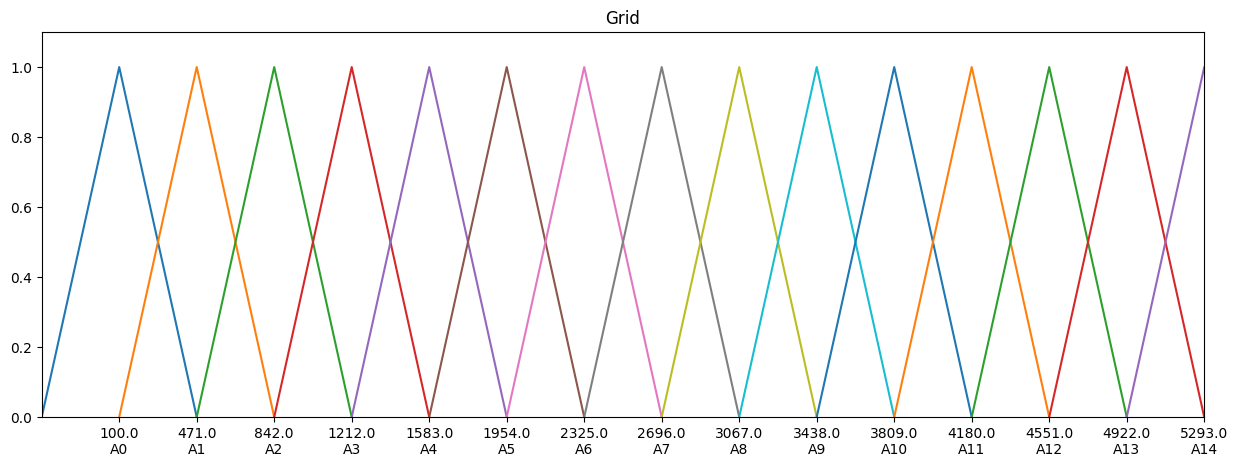

In [30]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [31]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [32]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A0', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A4', 'A6 -> A5', 'A5 -> A3', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A7 -> A5', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A11 -> A9', 'A10 -> A8', 'A8 -> A6', 'A9 -> A6', 'A9 -> A7', 'A8 -> A11', 'A11 -> A8', 'A10 -> A12', 'A11 -> A12', 'A12 -> A10', 'A12 -> A11', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [33]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A0,A1,A2
A2 -> A1,A2,A3
A3 -> A2,A3,A4
A4 -> A3,A4,A5
A5 -> A4,A5,A6,A7
A6 -> A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8,A9
A9 -> A10,A6,A8,A9
A10 -> A10,A11,A9
A11 -> A10,A11,A12
A12 -> A11,A12,A13
A13 -> A12



In [34]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [35]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 143.73264344419468
Testing RMSE: 185.84885363794805
Testing MAPE: 0.07452563111850197
Validation MAE: 122.11526967340406
Validation RMSE: 154.50146967562014
Validation MAPE: 0.04394971222949168


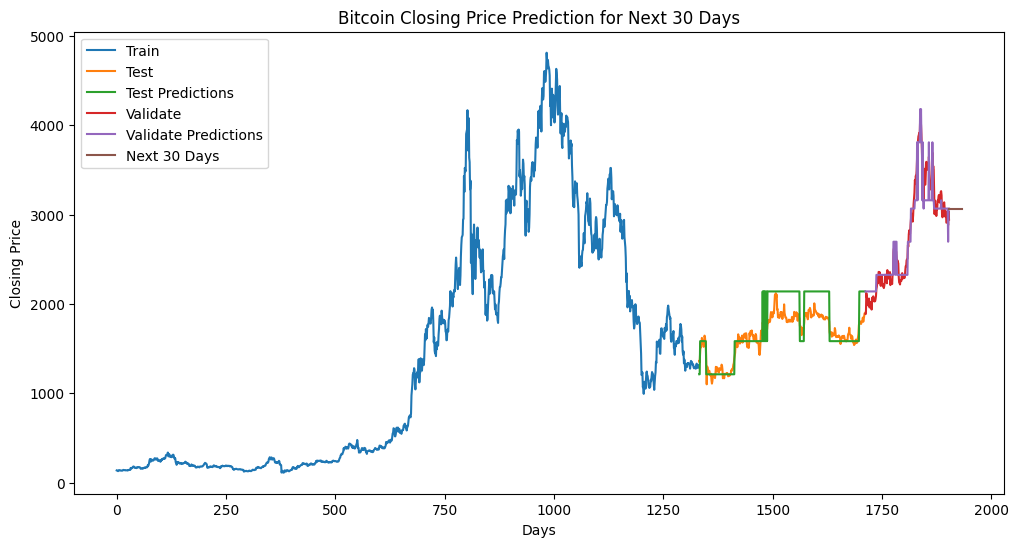

Predicted closing prices for the next 30 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802]


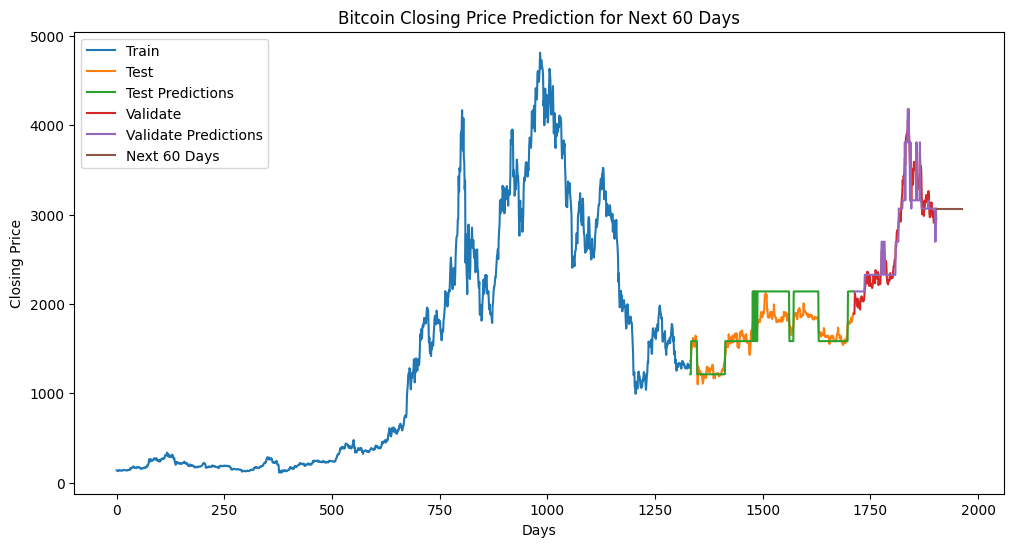

Predicted closing prices for the next 60 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802]


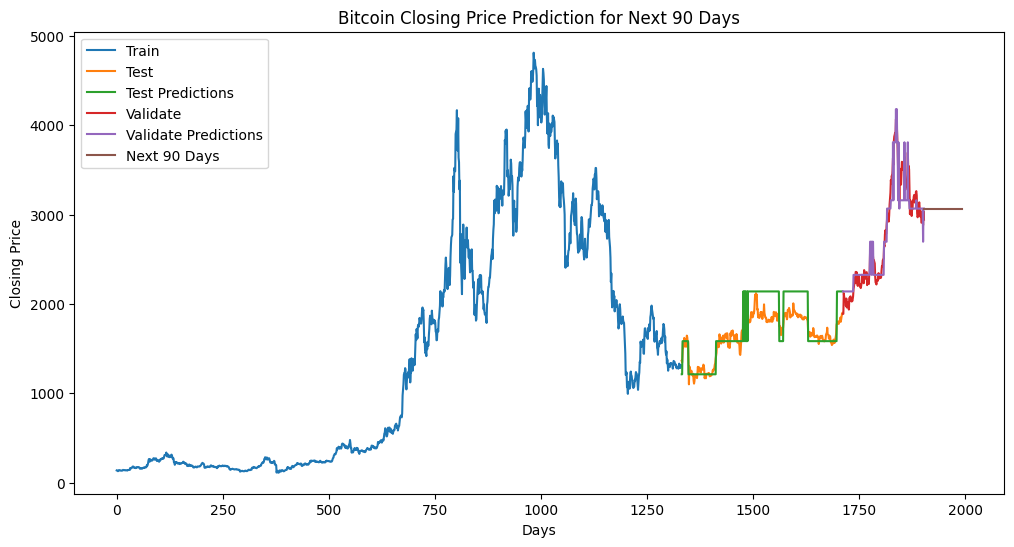

Predicted closing prices for the next 90 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3

In [36]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 6:2:2**

In [37]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('ETH.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [38]:
# 3. Chia train test validate theo tỉ lệ 6:2:2
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


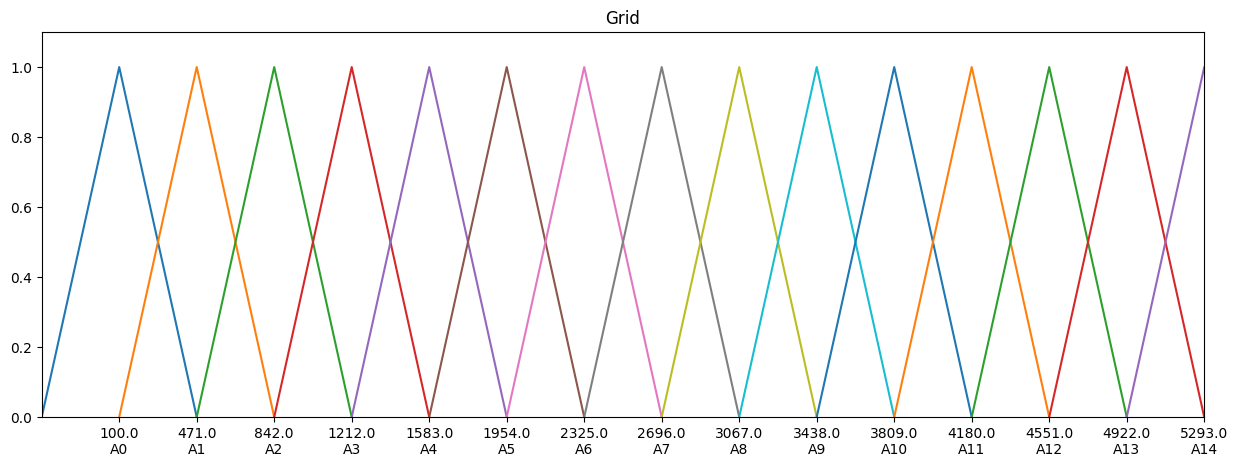

In [39]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [40]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [41]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A0', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A4', 'A6 -> A5', 'A5 -> A3', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A7 -> A5', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A11 -> A9', 'A10 -> A8', 'A8 -> A6', 'A9 -> A6', 'A9 -> A7', 'A8 -> A11', 'A11 -> A8', 'A10 -> A12', 'A11 -> A12', 'A12 -> A10', 'A12 -> A11', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [42]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A0,A1,A2
A2 -> A1,A2,A3
A3 -> A3,A4
A4 -> A4,A5
A5 -> A4,A5,A6,A7
A6 -> A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8,A9
A9 -> A10,A6,A8,A9
A10 -> A10,A11,A9
A11 -> A10,A11,A12
A12 -> A11,A12,A13
A13 -> A12



In [43]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [44]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 173.73237803110072
Testing RMSE: 195.9777015944886
Testing MAPE: 0.10096628335593959
Validation MAE: 169.97908672961498
Validation RMSE: 199.21304973223044
Validation MAPE: 0.07540471770111637


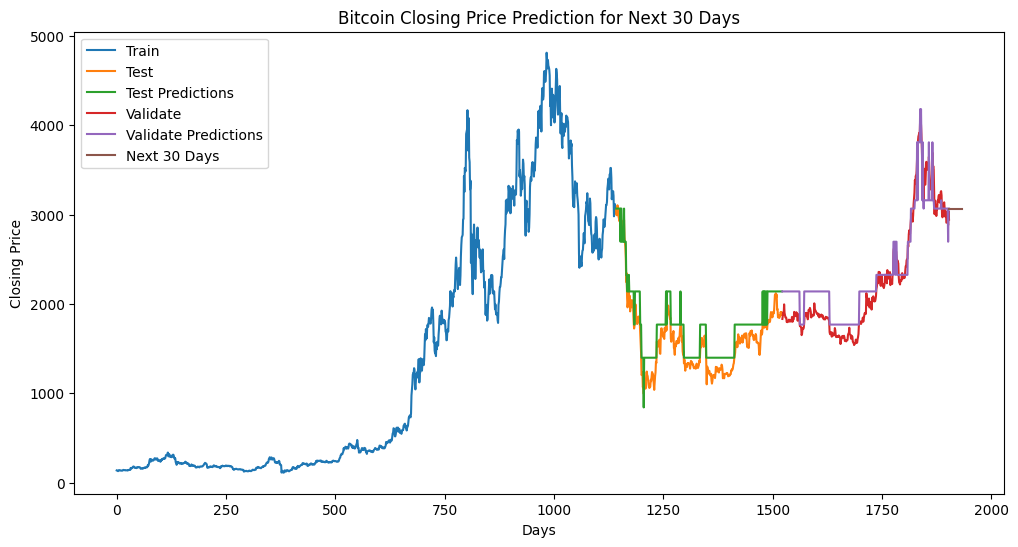

Predicted closing prices for the next 30 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802]


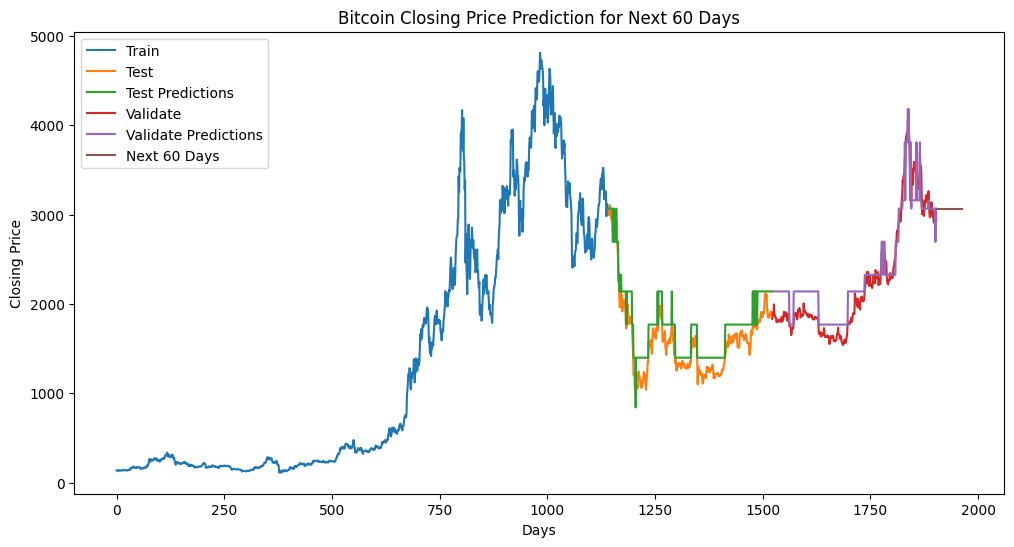

Predicted closing prices for the next 60 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802]


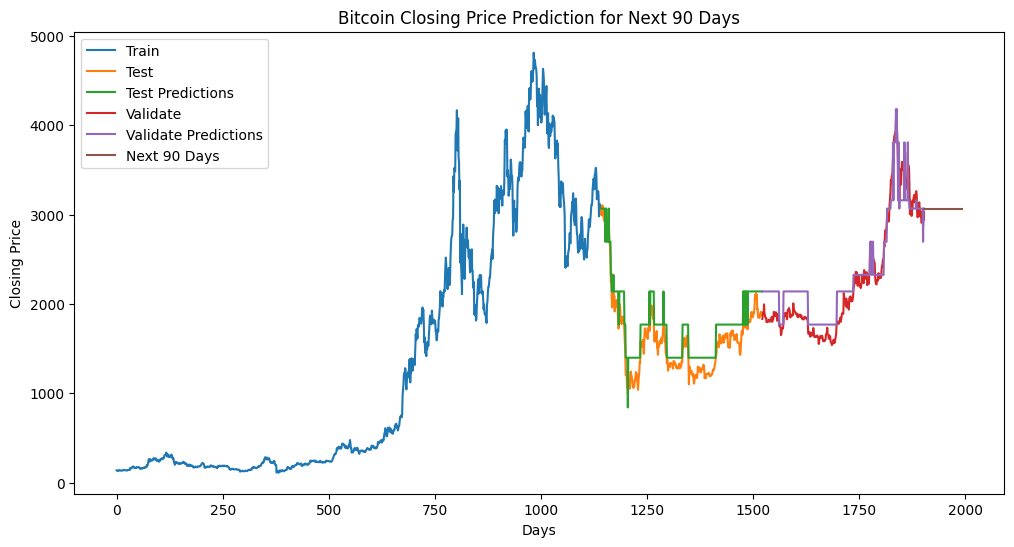

Predicted closing prices for the next 90 days:
[3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3067.40291802 3067.40291802 3067.40291802
 3067.40291802 3067.40291802 3

In [45]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())